<a href="https://colab.research.google.com/github/smlprasad/NLP-Project/blob/main/Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the libraries

!pip install emoji
import numpy as np
import pandas as pd
from google.colab import drive
from time import time
import re
import string
import os
from pprint import pprint
import collections
import emoji

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
'''
import gensim

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
'''
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import gensim


     |████████████████████████████████| 133kB 5.3MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
# Mount google Drive
drive.mount('/content/NLP')

Mounted at /content/NLP


In [5]:
# load dataset
df = pd.read_csv('NLP/MyDrive/NLP/Tweets.csv')

In [6]:
# Print Shape of data
df.shape

(14640, 15)

In [7]:
# Data Description
df.describe

<bound method NDFrame.describe of                  tweet_id  ...               user_timezone
0      570306133677760513  ...  Eastern Time (US & Canada)
1      570301130888122368  ...  Pacific Time (US & Canada)
2      570301083672813571  ...  Central Time (US & Canada)
3      570301031407624196  ...  Pacific Time (US & Canada)
4      570300817074462722  ...  Pacific Time (US & Canada)
...                   ...  ...                         ...
14635  569587686496825344  ...                         NaN
14636  569587371693355008  ...                         NaN
14637  569587242672398336  ...                         NaN
14638  569587188687634433  ...  Eastern Time (US & Canada)
14639  569587140490866689  ...                         NaN

[14640 rows x 15 columns]>

In [8]:
# Reindexing
df = df.reindex(np.random.permutation(df.index)) 
df.reset_index(inplace=True)
# Drop all other columns except “text” and “airline_sentiment”.
df.drop('index',inplace=True,axis=1)
df = df[['text', 'airline_sentiment']]

In [9]:
# Check the shape of data.
df.shape

(14640, 2)

In [10]:
# Print first 5 rows of data.
df.head()

,text,airline_sentiment
0,@united I booked and paid for a flight to get ...,negative
1,@united @RobBogart After I waited hours in the...,negative
2,@united why would you overnight my bag Wed to ...,negative
3,@SouthwestAir Hi! I ❤️ your company and fly al...,positive
4,@united negative. Done wasting time with amate...,negative


In [11]:
# Class to Count Texts in given corpus
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        #finding all the substring containing the pattern in the tweet
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        #all the alphanumeric character
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?+', x))
        count_urls = X.apply(lambda x: self.count_regex(r'https?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

tc = TextCounts()

df_eda = tc.fit_transform(df.text)
df_eda.head()


,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis
0,28,1,0,0,0,0,0
1,25,2,0,1,1,0,0
2,21,1,0,0,1,0,0
3,26,1,0,0,2,1,1
4,15,1,0,0,0,0,0


In [13]:
df_eda['airline_sentiment'] = df.airline_sentiment
df_eda.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,airline_sentiment
0,28,1,0,0,0,0,0,negative
1,25,2,0,1,1,0,0,negative
2,21,1,0,0,1,0,0,negative
3,26,1,0,0,2,1,1,positive
4,15,1,0,0,0,0,0,negative


In [14]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('airline_sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='airline_sentiment', size=5, hue='airline_sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count_words
---------------------------------
                    count       mean       std  min   25%   50%   75%   max
airline_sentiment                                                          
negative           9178.0  20.387557  6.100020  2.0  17.0  22.0  25.0  35.0
neutral            3099.0  15.290094  7.150738  2.0  10.0  15.0  21.0  34.0
positive           2363.0  14.478206  7.266129  2.0   8.0  14.0  21.0  33.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


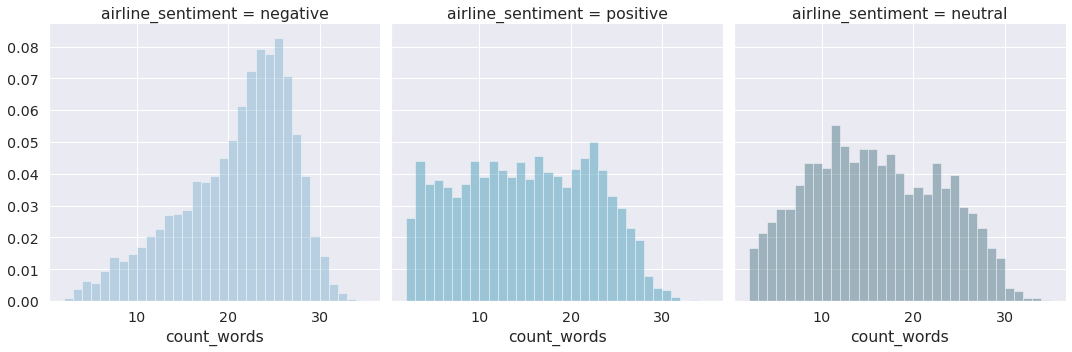

In [15]:
show_dist(df_eda, 'count_words')

Descriptive stats for count_mentions
------------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           9178.0  1.111244  0.365420  1.0  1.0  1.0  1.0  6.0
neutral            3099.0  1.167473  0.480102  1.0  1.0  1.0  1.0  5.0
positive           2363.0  1.138383  0.432462  1.0  1.0  1.0  1.0  6.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


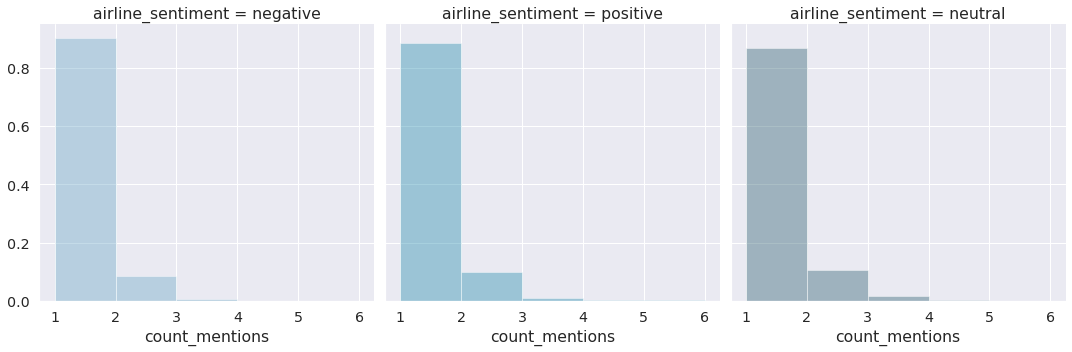

In [16]:
show_dist(df_eda, 'count_mentions')

Descriptive stats for count_hashtags
------------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           9178.0  0.233384  0.615099  0.0  0.0  0.0  0.0  6.0
neutral            3099.0  0.212004  0.666382  0.0  0.0  0.0  0.0  6.0
positive           2363.0  0.297503  0.774776  0.0  0.0  0.0  0.0  8.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


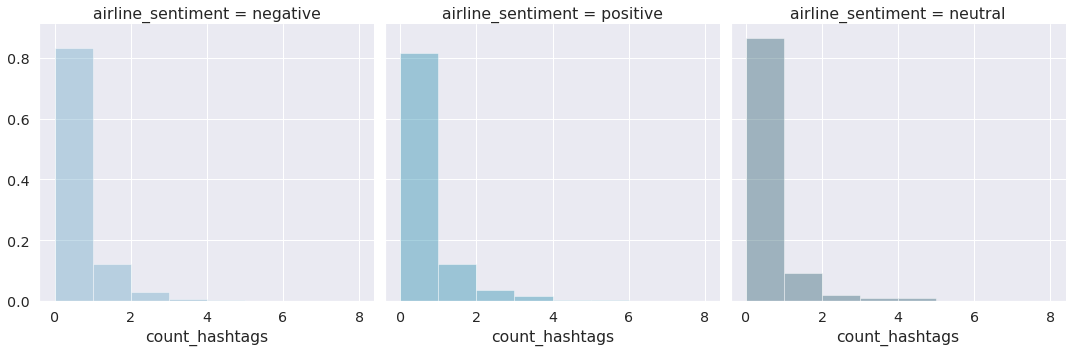

In [17]:
show_dist(df_eda, 'count_hashtags')

Descriptive stats for count_capital_words
-----------------------------------------
                    count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                      
negative           9178.0  0.429070  1.019710  0.0  0.0  0.0  1.0  22.0
neutral            3099.0  0.462085  0.939468  0.0  0.0  0.0  1.0  11.0
positive           2363.0  0.461278  1.234078  0.0  0.0  0.0  1.0  20.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


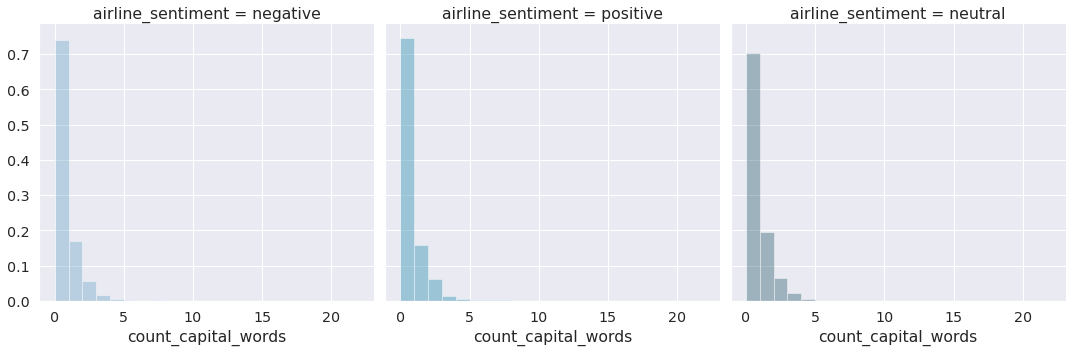

In [18]:
show_dist(df_eda, 'count_capital_words')

Descriptive stats for count_excl_quest_marks
--------------------------------------------
                    count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                      
negative           9178.0  0.589235  1.041339  0.0  0.0  0.0  1.0  27.0
neutral            3099.0  0.639238  0.868104  0.0  0.0  0.0  1.0  12.0
positive           2363.0  0.890394  1.198117  0.0  0.0  1.0  1.0  13.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


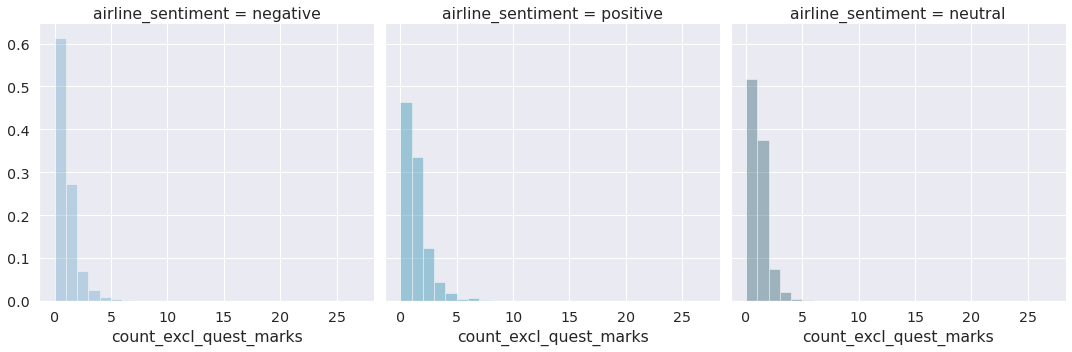

In [19]:
show_dist(df_eda, 'count_excl_quest_marks')

Descriptive stats for count_urls
--------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           9178.0  0.049248  0.218403  0.0  0.0  0.0  0.0  2.0
neutral            3099.0  0.169732  0.401225  0.0  0.0  0.0  0.0  3.0
positive           2363.0  0.098603  0.303818  0.0  0.0  0.0  0.0  2.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


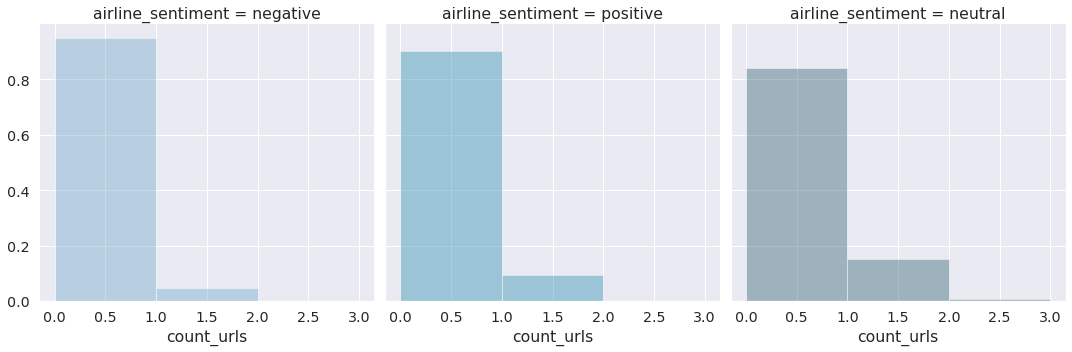

In [20]:
show_dist(df_eda, 'count_urls')

Descriptive stats for count_emojis
----------------------------------
                    count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                      
negative           9178.0  0.028547  0.258772  0.0  0.0  0.0  0.0   8.0
neutral            3099.0  0.075831  0.492415  0.0  0.0  0.0  0.0  13.0
positive           2363.0  0.181549  1.257512  0.0  0.0  0.0  0.0  40.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


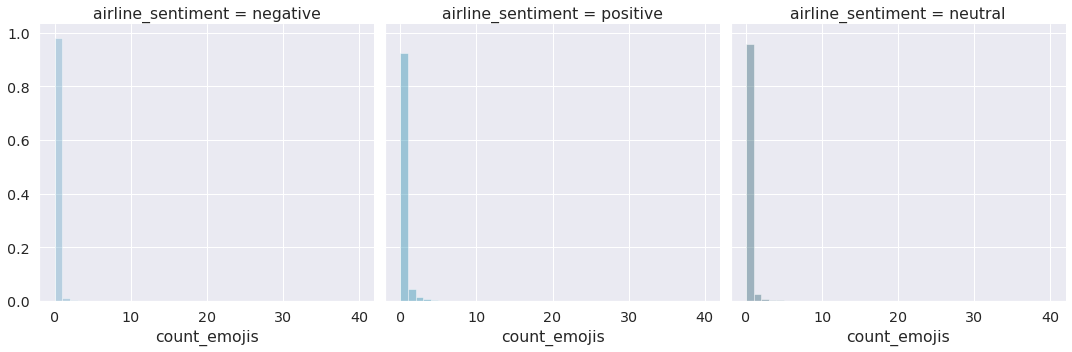

In [21]:
show_dist(df_eda, 'count_emojis')

In [22]:
# Class to perform Cleaning on given Text (HTML tag removal, )
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self

    def tokenize(self, input_text):
         word_tokens = word_tokenize(input_text)
         return word_tokens

    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [24]:
import nltk
nltk.download('stopwords')
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
ct = CleanText()
sr_clean = ct.fit_transform(df.text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [25]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

22 records have no words left after text cleaning


In [26]:
i=1
empty_clean = sr_clean == ''

print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'
print (sr_clean[0:5])

0 records have no words left after text cleaning
0    book paid flight get denver specif time meet f...
1     wait hour airport told one fib ual honest custom
2    would overnight bag wed unknown locat courier ...
3    hi ❤️ compani fli time wonder could pleas shar...
4    neg done wast time amateur custom servic thank...
Name: text, dtype: object


In [27]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
#printing only first 20
cv.get_feature_names()[0:20]
#bow.sum(axis=0)

['aa',
 'aaaand',
 'aaadvantag',
 'aaalwaysl',
 'aadavantag',
 'aadelay',
 'aadv',
 'aadvantag',
 'aafail',
 'aal',
 'aaron',
 'aaso',
 'aateam',
 'ab',
 'aback',
 'abandon',
 'abassinet',
 'abbrev',
 'abc',
 'abcletjetbluestreamfe']

      word  freq
0   flight  4879
1    thank  1703
2      get  1623
3      not  1586
4       no  1507
5     hour  1167
6   cancel  1065
7     help  1062
8    delay  1010
9   servic  1002
10    time   987
11  custom   947
12    call   792
13     bag   771
14    wait   754
15   plane   735
16      us   705
17     fli   702
18    need   688
19    hold   687


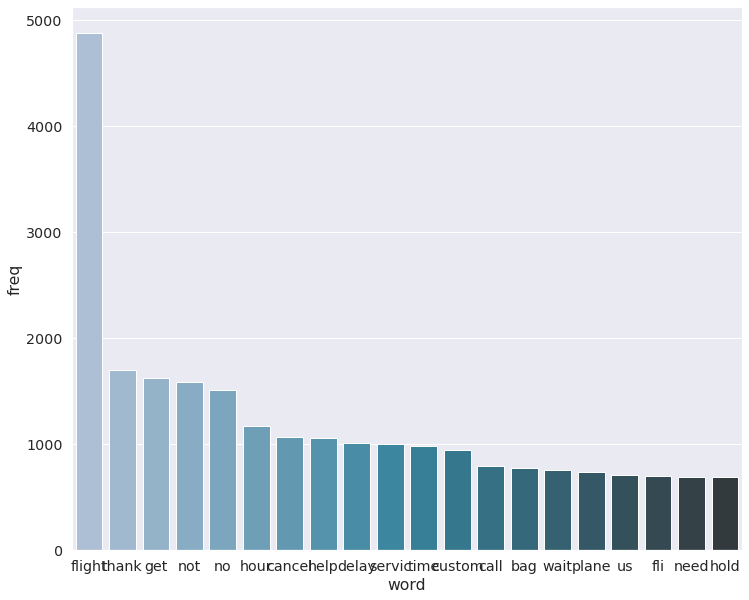

In [28]:
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
print(word_counter_df)

fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

In [29]:
df_model = df_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'airline_sentiment',
 'clean_text']

In [31]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment, test_size=0.1, random_state=37)

In [33]:
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        print("not good")
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        print("ok")
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=1)

    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_train, y_train))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
    print("Classification Report Train Data")
    print(classification_report(y_train, grid_search.best_estimator_.predict(X_train)))                    
    return grid_search

In [34]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}


# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}


# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (1.05, 1.1, 1.15,1.2),
    'clf__penalty': ('l1', 'l2')
}

In [35]:
mnb = MultinomialNB()
logreg = LogisticRegression()

In [36]:
# CountVectorizer.
countvect = CountVectorizer()

In [37]:
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)


ok
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.0min finished


done in 60.941s

Best CV score: 0.780
Best parameters set:
	clf__alpha: 0.5
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.785


Test score with best_estimator_: 0.882


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.82      0.91      0.86       905
     neutral       0.67      0.52      0.59       316
    positive       0.75      0.65      0.70       243

    accuracy                           0.78      1464
   macro avg       0.75      0.70      0.72      1464
weighted avg       0.78      0.78      0.78      1464

Classification Report Train Data
              precision    recall  f1-score   support

    negative       0.91      0.93      0.92      8273
     neutral       0.80      0.74      0.77      2783
    positive       0.85      0.88      0.86      2120

    accuracy                           0.88     13176
   macro avg

In [38]:
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)


ok
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (1.05, 1.1, 1.15, 1.2),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  7.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


done in 432.918s

Best CV score: 0.788
Best parameters set:
	clf__C: 1.2
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.772


Test score with best_estimator_: 0.831


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.83      0.88      0.86       905
     neutral       0.60      0.54      0.57       316
    positive       0.74      0.66      0.70       243

    accuracy                           0.77      1464
   macro avg       0.72      0.69      0.71      1464
weighted avg       0.77      0.77      0.77      1464

Classification Report Train Data
              precision    recall  f1-score   support

    negative       0.88      0.92      0.90      8273
     neutral       0.71      0.65      0.68      2783
    positive       0.77      0.73      0.75      2120

    accuracy                           0.83     13

In [39]:
# TfidfVectorizer
tfidfvect = TfidfVectorizer()

In [40]:
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

ok
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   56.6s finished


done in 57.151s

Best CV score: 0.750
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.751


Test score with best_estimator_: 0.849


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.75      0.96      0.84       905
     neutral       0.72      0.36      0.48       316
    positive       0.81      0.47      0.59       243

    accuracy                           0.75      1464
   macro avg       0.76      0.60      0.64      1464
weighted avg       0.75      0.75      0.72      1464

Classification Report Train Data
              precision    recall  f1-score   support

    negative       0.84      0.97      0.90      8273
     neutral       0.87      0.59      0.71      2783
    positive       0.88      0.70      0.78      2120

    accuracy                           0.85     13176
   macro av

In [41]:
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

ok
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (1.05, 1.1, 1.15, 1.2),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  7.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


done in 434.819s

Best CV score: 0.761
Best parameters set:
	clf__C: 1.2
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.745


Test score with best_estimator_: 0.774


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.79      0.92      0.85       905
     neutral       0.59      0.43      0.50       316
    positive       0.68      0.49      0.57       243

    accuracy                           0.74      1464
   macro avg       0.69      0.61      0.64      1464
weighted avg       0.73      0.74      0.73      1464

Classification Report Train Data
              precision    recall  f1-score   support

    negative       0.80      0.93      0.86      8273
     neutral       0.65      0.49      0.56      2783
    positive       0.76      0.53      0.63      2120

    accuracy                           0.77     1

### **Summarize your understanding of the application of Various Pre-processing and Vectorization and performance of your model on this dataset.**


# List of Text Preprocessing Steps
## Based on the general outline above, we performed a series of steps under each component.

1. Remove HTML tags
2. Remove extra whitespaces
3. Convert accented characters to ASCII characters
4. Expand contractions
5. Remove special characters
6. Lowercase all texts
7. Convert number words to numeric form
8. Remove numbers
9. Remove stopwords
10. Lemmatization






TF-IDF

Term Frequency - Inverse Document Frequency it makes sure that less importance is given to most frequent words and also considers less frequent words.

Term Frequency is number of times a particular word(W) occurs in a review divided by totall number of words (Wr) in review. The term frequency value ranges from 0 to 1.

Inverse Document Frequency is calculated as log(Total Number of Docs(N) / Number of Docs which contains particular word(n)). Here Docs referred as Reviews.

TF-IDF is TF * IDF that is (W/Wr)*LOG(N/n)

Using scikit-learn's tfidfVectorizer we can get the TF-IDF.

So even here we get a TF-IDF value for every word and in some cases it may consider different meaning reviews as similar after stopwords removal. so to over come we can use BI-Gram or NGram.

1. Vectorizer with MultinomialNB test score with best_estimator_: **0.882**
2. Vectorizer with LogisticRegression test score with best_estimator_: **0.831**
3. Test score with MultinomialNB best_estimator_: **0.849**
4. Test score with LogisticRegression best_estimator_: **0.774**

